Предлагается проходиться батчами по клиентам и получать распределения неожидаемых потерь в каждой симуляции. По этим распределениям можно построить доверительные интервалы для VaR 99.9
Итоговое распределение (картинку) можно получить, объеденив все симуляции

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

In [26]:
scores = pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_oot_with_score.parquet")  # .head(10_000)
scores.shape

(938821, 67)

In [3]:
scores.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,sec_app_earliest_cr_line,sec_app_mort_acc,sec_app_open_acc,sec_app_num_rev_accts,disbursement_method,target,debt_load,log_annual_inc,fraq_annual_inc,score
0,5000.0,5000.0,5000.0,36.0,20.39,186.82,general manager,8,RENT,50000.0,...,NaN,NaN,NaN,NaN,Cash,-1,0.044837,10.819798,NaN,0.462355
1,15000.0,15000.0,15000.0,36.0,9.92,483.45,it director,2,OWN,196000.0,...,NaN,NaN,NaN,NaN,Cash,-1,0.029599,12.185875,NaN,0.150798
2,11200.0,11200.0,11200.0,60.0,30.79,367.82,client services,0,RENT,44000.0,...,4776.0,1.0,14.0,8.0,Cash,-1,0.100315,10.691968,0.54321,0.557657
3,25000.0,25000.0,25000.0,60.0,21.85,688.35,asphalt supervisor,10,MORTGAGE,65000.0,...,NaN,NaN,NaN,NaN,Cash,-1,0.127080,11.082158,NaN,0.525946
4,3000.0,3000.0,3000.0,36.0,7.34,93.10,scale technician,9,RENT,52000.0,...,NaN,NaN,NaN,NaN,Cash,0,0.021485,10.859018,NaN,0.032529


In [94]:
sc_range = sorted(set(np.percentile(scores["score"], np.arange(50))) | set(np.linspace(0, 1, 50)))
max_profit = scores[scores["target"] == 0]["funded_amnt"].sum()
profits = []
for i in tqdm(sc_range):
    loss = scores[(scores["score"] < i) & (scores["target"] == 1)]["funded_amnt"].sum()
    profit = scores[(scores["score"] < i) & (scores["target"] == 0)]
    profit = (profit["installment"] * profit["term"] - profit["funded_amnt"]).sum()
    profits.append((profit - loss) / max_profit)

  0%|          | 0/100 [00:00<?, ?it/s]

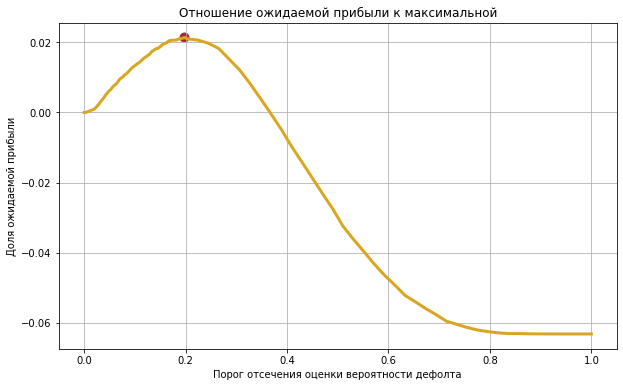

In [118]:
plt.figure(figsize=(10, 6), facecolor="w")
plt.plot(sc_range, profits, color="goldenrod", linewidth=3)
plt.scatter(sc_range[np.argmax(profits)], max(profits), s=80, c="brown")
plt.title("Отношение ожидаемой прибыли к максимальной")
plt.xlabel("Порог отсечения оценки вероятности дефолта")
plt.ylabel("Доля ожидаемой прибыли")
plt.grid()
plt.show()

In [112]:
best_thr = sc_range[np.argmax(profits)]
best_thr

0.19783943175212504

In [97]:
real_loss = (
    scores[(scores["score"] < best_thr) & (scores["target"] == 1)]["funded_amnt"].sum()
    / scores[scores["target"] == 1]["funded_amnt"].sum()
)
real_loss

0.1950277180376303

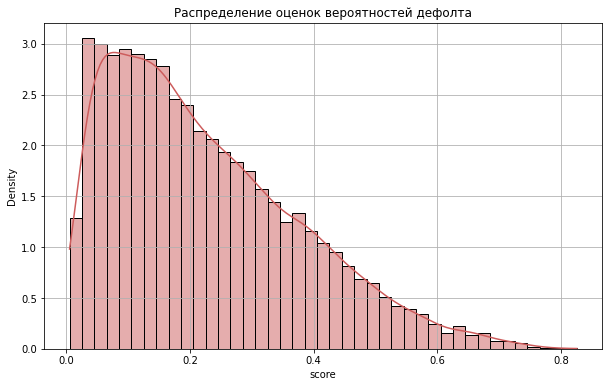

In [18]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(scores["score"], stat="density", kde=True, color="indianred")
plt.title("Распределение оценок вероятностей дефолта")
plt.grid()
plt.show()

In [48]:
exp = {"ul": [], "el": [], "var": [], "capital": []}
exp_corr = {"ul": [], "el": [], "var": [], "capital": []}
for i in tqdm(range(100)):
    scr = scores.sample(1000, random_state=i)
    el = (scr["funded_amnt"] * scr["score"]).sum() / scr["funded_amnt"].sum()

    rnd = np.random.RandomState(i)
    rnd_vec = rnd.uniform(size=(scr.shape[0], 1000)).astype(np.float32)
    ul = ((scr["score"].values[..., None] - rnd_vec > 0) * scr["funded_amnt"].values[..., None]).sum(axis=0) / scr[
        "funded_amnt"
    ].sum()
    exp["ul"].extend(rnd.choice(ul, 50))
    exp["var"].append(np.percentile(ul, q=99.9))
    exp["el"].append(el)
    exp["capital"].append(np.percentile(ul, q=99.9) - el)

    corr_matrix = np.ones((scr.shape[0], scr.shape[0])) * 0.06
    np.fill_diagonal(corr_matrix, 1)
    corr_matrix = np.linalg.cholesky(corr_matrix)
    rnd_vec = corr_matrix @ rnd_vec
    rnd_vec = ((rnd_vec.T - np.min(rnd_vec, axis=1)) / (np.max(rnd_vec, axis=1) - np.min(rnd_vec, axis=1))).T
    ul = ((scr["score"].values[..., None] - rnd_vec > 0) * scr["funded_amnt"].values[..., None]).sum(axis=0) / scr[
        "funded_amnt"
    ].sum()
    exp_corr["ul"].extend(rnd.choice(ul, 50))
    exp_corr["var"].append(np.percentile(ul, q=99.9))
    exp_corr["el"].append(el)
    exp_corr["capital"].append(np.percentile(ul, q=99.9) - el)

  0%|          | 0/100 [00:00<?, ?it/s]

Форма колокола говорит о том, что дефолты независимые и с одинаковой вероятностью реализуются события разной убыточности

In [74]:
np.mean(exp["capital"])

0.04557122711474519

In [75]:
np.mean(exp_corr["capital"])

0.14923679514548094

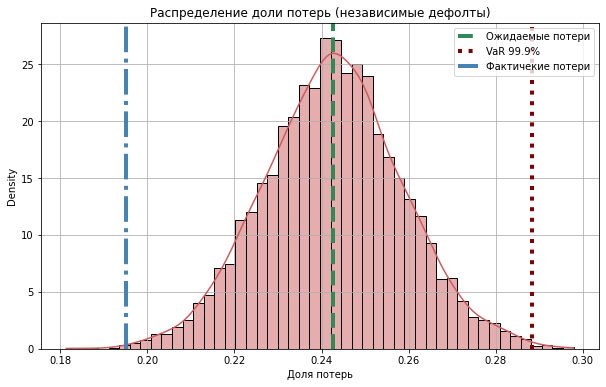

In [98]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(exp["ul"], stat="density", kde=True, color="indianred")
plt.axvline(np.mean(exp["el"]), color="seagreen", linestyle="--", linewidth=4, label="Ожидаемые потери")
plt.axvline(np.mean(exp["var"]), color="maroon", linestyle=":", linewidth=4, label="VaR 99.9%")
plt.axvline(real_loss, color="steelblue", linestyle="-.", linewidth=4, label="Фактичекие потери")
plt.title("Распределение доли потерь (независимые дефолты)")
plt.xlabel("Доля потерь")
plt.legend()
plt.grid()
plt.show()

Распределение имеет тяжелый хвост справа - это говорит о том, что для скоррелированных дефолтов чаще реализуются более негативные сценарии. При этом разброс потерь больше

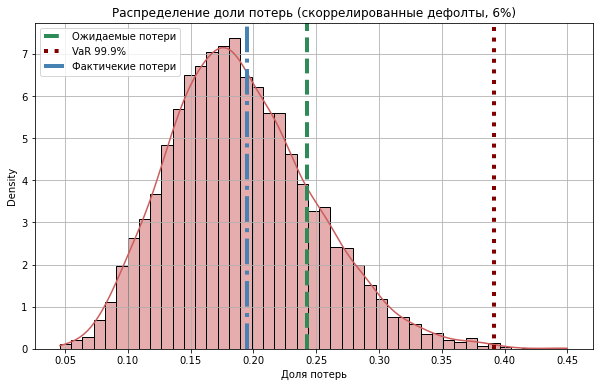

In [99]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(exp_corr["ul"], stat="density", kde=True, color="indianred")
plt.axvline(np.mean(exp_corr["el"]), color="seagreen", linestyle="--", linewidth=4, label="Ожидаемые потери")
plt.axvline(np.mean(exp_corr["var"]), color="maroon", linestyle=":", linewidth=4, label="VaR 99.9%")
plt.axvline(real_loss, color="steelblue", linestyle="-.", linewidth=4, label="Фактичекие потери")
plt.title("Распределение доли потерь (скоррелированные дефолты, 6%)")
plt.xlabel("Доля потерь")
plt.legend()
plt.grid()
plt.show()